In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd

import time

import random
import re

from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


from typing import List, Tuple, Dict

from tqdm import tqdm

In [5]:
data_path = 'gecodb_v01.tsv'

### Отбор данных [1 балл]

In [6]:
df = pd.read_csv(data_path, sep='\t', header=None)

In [7]:
df.columns = ['Word', 'Count']

In [8]:
df

,Word,Count
0,Zeit_Punkt,825790
1,Web_Seite,532934
2,Bund_+es_Regierung,437277
3,Welt_Krieg,419007
4,Mittel_Punkt,415822
...,...,...
22380128,20_--_iger_--_Jahr,1
22380129,20_--_er_--_Jahr,1
22380130,1960_--_iger_--_Jahr,1
22380131,1890_--_er_--_Jahr,1


Для начала отберём из множества слов только те, которые в качестве разделителя имеют ТОЛЬКО нижнее подчёркивание. Также не забываем о существовании букв немецкого алфавита. Регулярные выражения вам в помощь! :)

In [9]:
reg = r'[A-Za-zßäöüÄÖÜ_]*'

In [10]:
data = df[df['Word'].str.fullmatch(reg)]
data.shape

(5657833, 2)

Разумеется, вы можете взять больше слов, всё зависит от возможностей вашего компьютера. В нашем случае мы берём миллион слов.

In [11]:
data = data.sample(n=1000000)

Теперь посмотрим на количество нижних подчёркиваний в словах. Такая информация нам пригодится для разделения данных на тренировочную и тестовую выборки. Обе выборки должны получиться репрезентативными.

In [14]:
data['Word']

5390846               Hygiene_Sünde
9722348              Wanderer_Essen
2740889               Klang_Schauer
13851033     Passiv_Haus_Initiative
14275771       Not_Helfer_Tätigkeit
                     ...           
1481691                 Logo_Phobie
3685832                  Deich_Zone
2167460              Abwärme_Nutzer
10561768    Transponder_Park_System
14521632    Natur_Kautschuk_Auflage
Name: Word, Length: 1000000, dtype: object

In [15]:
underscores_counts = []
for i, word in enumerate(data['Word']):
    underscores_counts.append(word.count('_'))


In [16]:
underscores_counts = pd.core.series.Series(underscores_counts)

In [17]:
underscores_counts.describe()

count    1000000.000000
mean           1.295332
std            0.496574
min            1.000000
25%            1.000000
50%            1.000000
75%            2.000000
max            8.000000
dtype: float64

<Axes: >

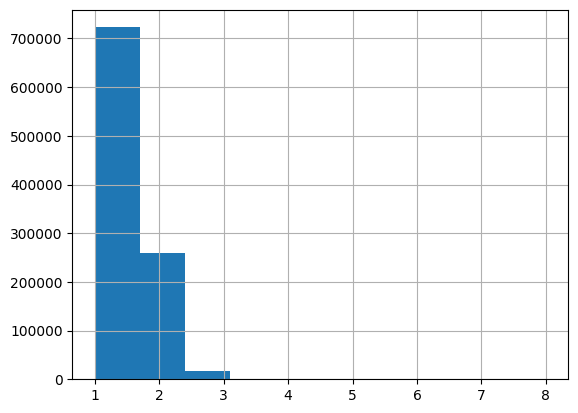

In [18]:
underscores_counts.hist()

<Axes: >

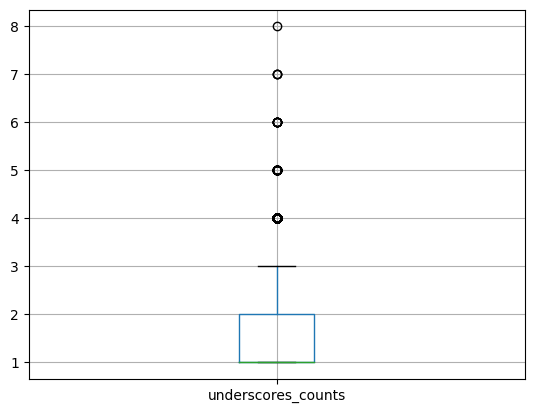

In [19]:
pd.DataFrame({'underscores_counts': underscores_counts}).boxplot()

In [20]:
underscores_counts.value_counts()

1    722944
2    259655
3     16589
4       766
5        34
6         8
7         3
8         1
dtype: int64

Создадим словари символов и тегов

In [21]:
chars = set([ch.lower() for word in data['Word'].values for ch in word if ch not in '_+'])
len(chars)

30

In [22]:
TAGS = (0, 1, 2)

char2index = {ch: i + 2 for i, ch in enumerate(list(chars))}
char2index['-OOV-'] = 1
char2index['-PAD-'] = 0
char2index[None] = 1

In [23]:
len(char2index)

33

### Простая разметка и разбиение данных на обучающую и тестовую выборку [2 балла]

Теперь займёмся предобработкой слов.

Для начала будем считать, что выходная последовательность состоит из двух чисел. Цифрой `1` будем указывать границу подстроки, то есть символ, стоящий перед `_`. В остальных случаях заполняем последовательность нулями.

Итак, заполним позиции символов следующим образом:

`0 - <Word-In>`

`1 - <Word-End>`

In [24]:
def simple_compound_annotation(word: str) -> str:
    """
    Данная функция кодирует слово в последовательность из 0 и 1
    1 - <Word-End> - буква, являющаяся границей подслова, т.е. стоящая перед `_`
    0 - <Word-In - в противном случае
    :param word: слово
    :return строка со списком
    """
    seq = []
    for let in word:
        if let == '_':
            seq[-1] = 1
        else:
            seq.append(0)
    return str(seq)

In [25]:
simple_compound_annotation('Zeit_Punkt')

'[0, 0, 0, 1, 0, 0, 0, 0, 0]'

In [26]:
data['Annotation'] = data['Word'].apply(simple_compound_annotation)

In [27]:
data['Underscores'] = list(underscores_counts)

In [28]:
data.head(3)

,Word,Count,Annotation,Underscores
5390846,Hygiene_Sünde,3,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1
9722348,Wanderer_Essen,1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1
2740889,Klang_Schauer,7,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1


Перемешаем слова, чтобы они не следовали в алфавитном порядке.

In [29]:
data = shuffle(data)
data.head(10)

,Word,Count,Annotation,Underscores
19757758,Echo_Licht,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0]",1
7422509,linear_Läufer,2,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1
18325710,Gehirn_Geburt,1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1
13749222,Pfanne_Gericht,1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1
2532304,Elektron_Euro,8,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",1
16977634,Inventur_Bilanz,1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1
7388377,Lust_Tropf,2,"[0, 0, 0, 1, 0, 0, 0, 0, 0]",1
4299345,Grog_Maschine,4,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",1
18706636,Form_Glas_Block,1,"[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]",2
3092262,Jagd_Theorie,6,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1


Разделим выборку на тренировочную и тестовую. Обратим внимание, что в распределении больше всего двусложных и трёхсложных слов. Поэтому мы их в первую очередь и возьмём в обучающие данные. А большую часть многосложных слов (особенно если их совсем немного) отправим в тестовую выборку.

На всякий случай, мы не берём в выборку слова, которые не содержат никаких подчёркиваний :)

Также никто не мешает вам создать валидационную выборку и потом корректировать по ней качество модели :)

In [30]:
set(underscores_counts)

{1, 2, 3, 4, 5, 6, 7, 8}

In [31]:
train = data[data['Underscores'] <= 3]

In [32]:
train, test = train_test_split(train, test_size=0.13)
train, val = train_test_split(train, test_size=0.1)

In [33]:
test = pd.concat([test, data[data['Underscores'] >= 3]])

In [34]:
train.shape, test.shape

((782363, 4), (147296, 4))

In [35]:
train = shuffle(train)
test = shuffle(test)
val = shuffle(val)

In [36]:
train.Underscores.value_counts()

1    566088
2    203258
3     13017
Name: Underscores, dtype: int64

In [37]:
test.Underscores.value_counts()

1    94005
2    33771
3    18708
4      766
5       34
6        8
7        3
8        1
Name: Underscores, dtype: int64

In [38]:
[ch.lower() for word in data['Word'].values for ch in word if ch not in '_+']

['e',
 'c',
 'h',
 'o',
 'l',
 'i',
 'c',
 'h',
 't',
 'l',
 'i',
 'n',
 'e',
 'a',
 'r',
 'l',
 'ä',
 'u',
 'f',
 'e',
 'r',
 'g',
 'e',
 'h',
 'i',
 'r',
 'n',
 'g',
 'e',
 'b',
 'u',
 'r',
 't',
 'p',
 'f',
 'a',
 'n',
 'n',
 'e',
 'g',
 'e',
 'r',
 'i',
 'c',
 'h',
 't',
 'e',
 'l',
 'e',
 'k',
 't',
 'r',
 'o',
 'n',
 'e',
 'u',
 'r',
 'o',
 'i',
 'n',
 'v',
 'e',
 'n',
 't',
 'u',
 'r',
 'b',
 'i',
 'l',
 'a',
 'n',
 'z',
 'l',
 'u',
 's',
 't',
 't',
 'r',
 'o',
 'p',
 'f',
 'g',
 'r',
 'o',
 'g',
 'm',
 'a',
 's',
 'c',
 'h',
 'i',
 'n',
 'e',
 'f',
 'o',
 'r',
 'm',
 'g',
 'l',
 'a',
 's',
 'b',
 'l',
 'o',
 'c',
 'k',
 'j',
 'a',
 'g',
 'd',
 't',
 'h',
 'e',
 'o',
 'r',
 'i',
 'e',
 'p',
 'h',
 'a',
 'n',
 't',
 'a',
 's',
 'i',
 'e',
 'd',
 'r',
 'a',
 'c',
 'h',
 'e',
 'n',
 'o',
 'r',
 'd',
 'o',
 's',
 't',
 's',
 'c',
 'h',
 'o',
 't',
 't',
 'i',
 's',
 'c',
 'h',
 'a',
 'l',
 'b',
 'u',
 'm',
 'a',
 'u',
 's',
 'k',
 'o',
 'p',
 'p',
 'l',
 'u',
 'n',
 'g',
 'k',
 'u'

In [120]:
def list2tensor(l):
    return torch.tensor(l, dtype=torch.long)

def encode_words(words: List[str]) -> List[List[float]]:
    """
    Напишите функцию, кодирующую слова в последовательности символьных кодов
    Обратите внимание на то, чтобы функция умела обрабатывать символы, которых нет в словаре.
    Также не забываёте о том, что все нижние подчёркивания и маркеры для инфиксов должны быть удалены из слов.
    Чтобы быстрее обрабатывать слова, рекомендуется вместо питоновских списков использвать функцию np.zeros(...)
    и затем добавлять код символа по индексу

    :param words: список слов
    :return массив с тензорами, состоящими из символьных кодов
    """
    words_X = []
    for word in words:
        word = [ch.lower() for ch in word if ch not in '_+' ]
        enc = np.zeros(len(word))
        for i in range(len(word)):
            enc[i] = char2index[word[i]] if  word[i] in char2index else char2index[None]
        
        words_X.append(list2tensor(enc))
    # YOUR CODE HERE
    return words_X

def encode_tags(tags):
    return [list2tensor(eval(ts)) for ts in tags]

In [43]:
train_x, train_y = encode_words(train['Word'].values), encode_tags(train['Annotation'].values)

In [79]:
val_x, val_y = encode_words(val['Word'].values), encode_tags(val['Annotation'].values)

In [44]:
test_x, test_y = encode_words(test['Word'].values), encode_tags(test['Annotation'].values)

In [123]:
train_x

[tensor([ 6, 21, 15,  8, 13, 13,  2,  8, 26,  6, 24, 27,  8, 24, 28]),
 tensor([ 3,  8, 15,  2, 23,  3,  6, 10, 28,  9,  6, 21, 27,  8, 24,  2]),
 tensor([ 9, 16, 15, 28,  8, 24,  2, 16, 24, 13, 26,  3, 18, 15, 28,  6]),
 tensor([13, 10, 25, 16, 26, 23,  2,  6, 24, 28, 11,  8, 15]),
 tensor([13, 26, 21,  8, 26,  6, 19, 12,  6, 13, 20, 12,  6, 15,  3,  6, 15, 26]),
 tensor([ 8, 13, 26,  6, 21, 18, 12,  2, 24,  5, 25,  6]),
 tensor([ 2, 12,  6, 24, 13, 26, 19,  6, 27,  6, 21, 12, 24,  4, 18]),
 tensor([25,  8, 16, 20, 26, 13, 26,  8,  2, 26, 13, 12,  6, 19]),
 tensor([13, 10, 25, 15, 31, 13, 13,  6, 15, 27,  6, 12, 24, 27, 21, 16, 10, 25,
         26, 25,  6, 11,  8]),
 tensor([30,  8, 19,  2, 20, 15,  8, 28,  8, 26]),
 tensor([25,  6, 15, 12, 14,  4, 18, 21, 11]),
 tensor([25, 16,  4,  6, 12, 13,  6, 24, 27,  8, 16]),
 tensor([20,  8, 13, 10,  8, 15, 13,  7, 24, 26,  8, 14]),
 tensor([25, 12, 21, 13, 10, 25, 27,  6, 16, 26,  6, 15, 26, 21,  5, 19,  6, 21]),
 tensor([25, 18, 10, 25,  2, 

### Разделитель слов [3 балла]

Построим сегментатор на основе символьной языковой модели.

In [131]:
class BiLSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, dropout=0.2):
        super(BiLSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim, 1, bidirectional=True) # двунаправленный LSTM-слой
        self.dense = nn.Linear(hidden_dim * 2, tagset_size)
        self.dropout = nn.Dropout(dropout) # позволим нашей модели не переобучаться на трейне :)

    def forward(self, word):
        """
        Напишите код для архитектуры сети
        В конце вам может пригодиться softmax
        """
        x = self.embeddings(word) 
        x = self.dropout(x)
        x, _ = self.bilstm(x)
        x = self.dense(x)
        # tag_scores = nn.Softmax(dim=1).forward(x)
        return x

Обучение

In [132]:
EMBEDDING_DIM = 32
HIDDEN_DIM = 32
N_EPOCHS = 3
N_TAGS = 2

In [133]:
BATCH_SIZE = 32

In [146]:
@torch.no_grad()
def print_metrics(model,  val_x_, val_y_, batch_size=BATCH_SIZE, name="", **kw):
    model.eval()
    # YOUR CODE HERE
    index = np.random.randint(len(val_x_))

    score = 0
    counter = 0
    for x, y in zip(val_x_[index:min(len(val_x_), index + batch_size)], val_y_[index:min(len(val_x_), index + batch_size)]):
        y_pred = model(x)
        score += accuracy_score(y, y_pred.argmax(dim=1))
        counter += 1

    return score / counter

    # Берите любые метрики, которые хотите оценивать на валидационной выборке

In [148]:
model = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(char2index), N_TAGS)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [149]:
for epoch in range(N_EPOCHS):
    model.train()
    running_loss = 0.0
    for i, (word_in, targets) in enumerate(zip(train_x, train_y)):
        model.zero_grad()
        tag_scores = model(word_in)
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

        # print statistics

        running_loss += loss.item()
        if i % 10000 == 9999:
            print(f'[{epoch + 1}, {i + 1:5d}/{len(train_x)}] loss: {running_loss / 10000:.3f}')
            print('val metric: ', print_metrics(model, val_x, val_y, max_len=128))
            running_loss = 0.0

    ### здесь может быть оценена ваша валидационная выборка
    # print_metrics(model, val_x, val_y, max_len=128)

[1, 10000/782363] loss: 0.158
val metric:  0.9667458843240093
[1, 20000/782363] loss: 0.104
val metric:  0.9757677218614719
[1, 30000/782363] loss: 0.091
val metric:  0.963147534211313
[1, 40000/782363] loss: 0.082
val metric:  0.9860337885154061
[1, 50000/782363] loss: 0.076
val metric:  0.9620640111594059
[1, 60000/782363] loss: 0.072
val metric:  0.9882311698717949
[1, 70000/782363] loss: 0.069
val metric:  0.9667796116422278
[1, 80000/782363] loss: 0.066
val metric:  0.9689764038206375
[1, 90000/782363] loss: 0.065
val metric:  0.966094486250978
[1, 100000/782363] loss: 0.063
val metric:  0.9911278842345018
[1, 110000/782363] loss: 0.060
val metric:  0.9837493121827003
[1, 120000/782363] loss: 0.059
val metric:  0.965258155157536
[1, 130000/782363] loss: 0.059
val metric:  0.979661688393306
[1, 140000/782363] loss: 0.057
val metric:  0.9870568539915966
[1, 150000/782363] loss: 0.056
val metric:  0.9861076670040486
[1, 160000/782363] loss: 0.056
val metric:  0.9794006500626568
[1, 1

KeyboardInterrupt: 

In [150]:
predicts = [model(x) for x in test_x]



In [152]:
y_true = [l.detach().numpy() for seq in test_y for l in seq]
y_pred = [0 if l.detach().numpy()[0] > l.detach().numpy()[1] else 1 for seq in predicts for l in seq]

In [153]:
target_names = ('Word-In', 'Word-End')

print(classification_report(y_true , y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Word-In       0.99      0.99      0.99   2031876
    Word-End       0.94      0.90      0.92    220982

    accuracy                           0.98   2252858
   macro avg       0.96      0.95      0.95   2252858
weighted avg       0.98      0.98      0.98   2252858



### Усложним нашу разметку для инфиксов [1 балл]

Пусть нашему инфиксу будет присваиваться код 2 (`Infix-End`). В итоге мы будем иметь три тега.

In [ ]:
def encode_complex_compound_annotation(word):
    """
    Данная функция кодирует слово в последовательность из 0 и 1
    2 - <Infix-End> - буква, являющаяся границей инфикса, т.е. последняя перед `+`
    1 - <Word-End> - буква, являющаяся границей подслова, т.е. стоящая перед `_`
    0 - <Word-In - в противном случае
    :param word: слово
    :return строка со списком
    """
    seq = []
    # YOUR CODE HERE
    return str(seq)

In [ ]:
encode_complex_compound_annotation('Vertrieb_+s_Netz_Planung')

'[0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]'

### Обучите ту же модель для новой разметки [3 балла]

1. Объединим первую обучающую выборку с подвыборкой, в которой находятся инфиксы. Размер подвыборки с инфиксами возьмите в таком расчёте: `x = (количество_слов_с_инфиксами * N_sample)/(количество_слов_только_с_подчёркиванием)`, где `N_sample` - число слов только с подчёркиванием, которые мы взяли в первой выборке

 - N_sample в нашем случае равен 1000000
 - количество_слов_только_с_подчёркиванием, количество_слов_с_инфиксами - ответ находится в команде shape

2. Запускаем обучение (можно использовать валидационную выборку)
3. Оцениваем качество и описываем выводы

В пункте 1 не забываем разделить выборку на train, val и test :)

In [ ]:
infixes_data['Annotation'] = infixes_data['Word'].apply(encode_complex_compound_annotation)

In [ ]:
full_train = ...
full_val = ...
full_test = ...

Обучение

In [ ]:
EMBEDDING_DIM = 32
HIDDEN_DIM = 32
N_EPOCHS = 3
N_TAGS = 3

In [ ]:
model = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(char2index), N_TAGS)
loss_function = ...
optimizer = ...

In [ ]:
sum(p.numel() for p in model.parameters())

### Придумайте, как можно улучшить качество на втором типе разметки [2 балла]

Идеи

- добавить в архитектуру больше слоёв
- подумать, можно ли здесь применить attention-механизм
- а может здесь имеет смысл дообучение первой модели на новых данных?
- ваши пожелания :)